# Find epochs with concurrent neural and watch data

For subjects with paired neural and watch streaming, here is some example code to find both neural and watch data. There are a two ways to check for multimodal data availability:

### 1. Using the `availability` expression
This method checks for neural and accelerometry data availability with the `availability` expression in their respective endpoints. The user specifies a resolution of interest (per day, per hour, per 10 minutes, etc.), and the API request will output 0's and 1's for data availability per time bin.

**Pros**: Can broadly search for data availability across time. Fast if you use low resolution (ie per day)

**Cons**: You may need to run multiple API calls looking for availability on different resolutions. Does not yield *exact* time points for start/end of recordings. The finest resolution available is 5 minute bins.

### 2. Using the Graph API
This method uses the Graph API to get information about neural and watch sessions, from which we can get the start/end times and then check for overlapping times.

**Pros**: Exact time points for start/end of neural and accel sessions.

**Cons**: Apple Watch 'sessions' are automatically segemented into 15 min epochs, so 1 continuous recording may actually be several sessions (ie 'sessions' on the Apple Watch and RC+S are not the same). The Graph API is not very user friendly.


In [1]:
import datetime
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from runeq import Config, stream
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

### Functions using the availability expression
The functions below at wrapper functions for checking neural and accelerometry data availability.

In [2]:
def check_neural_data_availability(client, params):
    '''
    Finds neural data availability within some time frame
    Outputs: dataframe with 0's and 1's for data availability at certain timestamps
    '''

    accessor = client.LFP(expression='availability(lfp)', **params)
    
    df = pd.DataFrame()
    for page in accessor.iter_json_availability():
        df_page = pd.DataFrame() 
        for idx, key in enumerate(page['data'].keys()):      
            df_page.insert(idx, key, page['data'][key])
        df_page.insert(0, 'time', page['time']) 
        df = df.append(df_page, ignore_index=True)
    
    return df
        

def check_accel_data_availability(client, params):
    '''
    Finds accel data availability within some time frame
    Outputs: dataframe with 0's and 1's for data availability at certain timestamps
    '''

    accessor = client.Accel(expression='availability(accel)', **params)
    
    df = pd.DataFrame()
    for page in accessor.iter_json_availability():
        df = pd.DataFrame(page['availability(accel)']) 
        df.insert(0, 'time', page['time']) 
    
    return df

### Functions for finding data epochs

These functions are from the previous notebook `03_advanced_neural_data_selection`.

In [3]:
def find_epochs(timestamp_series, state_series, state_match):
    '''
    Returns start/stop time of data epochs based off state changes
    For example, we want to find all data epochs in which sampling rate == 250 
    Each epoch starts when the first sampling rate event == 250 
    Each epoch ends when sampling rate changes to different value
    
    Input: 
        time_series - unix time stamps for each state <pd series>
        state_series - values for a particular state <pd series>
        state_match - desired state value <int, float, or string>
    Output: 
        epochs - list of unix time stamps for epoch start/stop
    '''
   
    # calculate changes in adjacent values to identify state changes
    match = pd.DataFrame([1 if x == state_match else 0 for x in state_series])
    match['change'] = match.diff()
    
    # when 'change' is 0, then a current value is identical to the previous value
    # an epoch begins when the change value is 1
    # an epoch ends when the change value is -1
    start_idx = [((np.isnan(x) and y == 1) or x == 1) for x,y in zip(match['change'],match[0])]
    stop_idx = [x == -1 for x in match['change']]
    
    # obtain datetime stamps for the start and stop of all epochs
    window_start = timestamp_series[start_idx]
    window_stop = timestamp_series[stop_idx]

    # if the last epoch has no stop, add the last datetime stamp as the stop
    if len(window_start) > len(window_stop):
        window_stop.loc[len(window_stop)] = timestamp_series.iloc[-1]
        
    # make array of start/stop times
    epochs = np.array([window_start[:], window_stop[:]]).transpose()

    return epochs


def find_overlapping_epochs(*conditions):
    '''
    Return epochs where all conditions are true.

    Input:
        One or more conditions. Each condition is a list of epochs.
        Each epoch is a list/tuple with 2 elements: the start and
        end time of a time interval where the condition was true.

    Output:
        A list of tuples, where each tuple represents the start and
        end time of an epoch where all the conditions are true
    '''

    # Compile a set of all the timestamps (the start times AND
    # end times of any of our conditions).
    times = set()

    # Also create a dictionary that summarizes the overall change at
    # each timestamp: the net number of conditions that "turn on" (or
    # "become" true).
    change_at_time = defaultdict(int)

    for condition in conditions:
        for epoch in condition:
            start, end = epoch
            times.add(start)
            times.add(end)
            # When a condition starts, the change at time t is positive
            change_at_time[start] += 1
            # When a condition ends, the change at time t is negative
            change_at_time[end] -= 1

    results = []

    # Now go through the timestamps *in order*, and keep track of
    # the cumulative sum of change_at_time:
    num_on = 0

    num_conditions = len(conditions)

    # When we find a timestamp where all of the conditions are true
    # (i.e. cumulative sum = num_conditions), we'll keep track of the
    # start time:
    current_epoch_start = None

    for time in sorted(times):
        num_on += change_at_time[time]
        if num_on == num_conditions and current_epoch_start == None:
            current_epoch_start = time

        if num_on != num_conditions and current_epoch_start != None:
            results.append((current_epoch_start, time))
            current_epoch_start = None

    if not results:
        print('No epochs matching all criteria')

    return results


def plot_epochs(condition_names, *conditions):
    '''
    Plots one or more conditions and the times in which those conditions were met

    Input:
        List of condition names and list of start/end times for epochs matching each condition
    '''

    num_conditions = len(conditions)

    fig, ax = plt.subplots(figsize=(12, 5))

    for idx, condition in enumerate(conditions):
        for epoch in condition:
            ax.plot([datetime.datetime.fromtimestamp(epoch[0]), datetime.datetime.fromtimestamp(epoch[1])], [idx, idx],
                    linewidth=25)

    plt.xticks(rotation=90)
    plt.yticks(np.arange(num_conditions), condition_names)
    plt.tight_layout()
    plt.xlabel('Time')
    plt.ylabel('Filter Criteria')
    plt.title('Data Availability')

Be sure to obtain the credentials for the RC+S in addition to the Apple Watch, and to use the appropriate device_id when checking for neural/accel data availability. 

## 1. Using the `availability` expression

In [4]:
# set up client

cfg = Config('/Users/witney/Documents/api_config/adbs05_config.yaml')
client = stream.V1Client(cfg)

### Example 1

In a single patient, we will check for data availability on a daily basis for the month of March 2020.

In [5]:
# initialize neural availability parameters

neural_params = {
    'device_id': 'c0Cg11Ub',
    'start_time': datetime.datetime(2020,3,1).timestamp(),     # unix time stamp
    'end_time': datetime.datetime(2020,4,1).timestamp(),       # unix time stamp
    'channels': '0,1,2,3',
    'resolution': 60 * 60 * 24,                                # time in sec
    'timestamp': 'unix'
}

In [6]:
# initialize accel availability parameters

accel_params = {
    'device_id': '6*yEoMb2',
    'start_time': datetime.datetime(2020,3,1).timestamp(),     # unix time stamp
    'end_time': datetime.datetime(2020,4,1).timestamp(),       # unix time stamp
    'resolution': 60 * 60 * 24,                                # time in sec   
    'timestamp': 'unix'
}

In [7]:
# check data availability with daily resolution

neural_data_avail_daily = check_neural_data_availability(client, neural_params)
accel_data_avail_daily = check_accel_data_availability(client, accel_params)

In [8]:
# days with both accel + neural

all_avail_daily = neural_data_avail_daily.time[(neural_data_avail_daily['channel.0'] == 1) & (accel_data_avail_daily[0] ==1)]

In [9]:
# print days with both channel 0 and accel recordings

pd.to_datetime(all_avail_daily, unit='s')

4    2020-03-05
5    2020-03-06
6    2020-03-07
7    2020-03-08
8    2020-03-09
9    2020-03-10
10   2020-03-11
11   2020-03-12
12   2020-03-13
13   2020-03-14
14   2020-03-15
15   2020-03-16
17   2020-03-18
18   2020-03-19
19   2020-03-20
20   2020-03-21
21   2020-03-22
22   2020-03-23
23   2020-03-24
24   2020-03-25
26   2020-03-27
27   2020-03-28
28   2020-03-29
29   2020-03-30
Name: time, dtype: datetime64[ns]

### Example 2

Next, we will check data availability with a higher resolution (every 10 minutes) in the same time frame.

In [10]:
neural_data_avail_fine_res = pd.DataFrame()
accel_data_avail_fine_res = pd.DataFrame()

# loop through all the days in our time range and check for data per 10 min bin
for start_day in all_avail_daily:
    start_time = start_day
    end_time = start_day + 60*60*24
    neural_params = {
        'device_id': 'c0Cg11Ub',
        'start_time': datetime.datetime(2020,3,1).timestamp(),
        'end_time': datetime.datetime(2020,4,1).timestamp(),
        'channels': '0,1,2,3',
        'resolution': 60*10,
        'timestamp': 'unix'
    }
    accel_params = {
        'device_id': '6*yEoMb2',
        'start_time': datetime.datetime(2020,3,1).timestamp(),
        'end_time': datetime.datetime(2020,4,1).timestamp(),
        'resolution': 60*10,    
        'timestamp': 'unix'
    }
    neural_day = check_neural_data_availability(client, neural_params)
    neural_data_avail_fine_res = neural_data_avail_fine_res.append(neural_day)
    accel_day = check_accel_data_availability(client, accel_params)
    accel_data_avail_fine_res = accel_data_avail_fine_res.append(accel_day)

In [11]:
# find overlapping epochs from the timestamps

# timestamps with both neural + accel data
neural_and_accel_time = neural_data_avail_fine_res.time[(neural_data_avail_fine_res['channel.0'] == 1) & (accel_data_avail_fine_res[0] ==1)]

# set up dataframe for find_epochs
epochs_neural_and_accel = pd.DataFrame()
epochs_neural_and_accel['time'] = neural_data_avail_fine_res.time
epochs_neural_and_accel['state'] = np.zeros(len(epochs_neural_and_accel))
for idx in np.arange(len(neural_and_accel_time)):
    epochs_neural_and_accel.at[neural_and_accel_time.index[idx],'state'] = 1
   
# epochs with neural + accel data
epochs_neural_and_accel = find_epochs(epochs_neural_and_accel.time, epochs_neural_and_accel.state, 1)

In [12]:
# find individual epochs

epochs_neural = find_epochs(
    neural_data_avail_fine_res.time, 
    neural_data_avail_fine_res['channel.0'], 
    1
)
epochs_accel = find_epochs(
    accel_data_avail_fine_res.time, 
    accel_data_avail_fine_res[0], 
    1
)

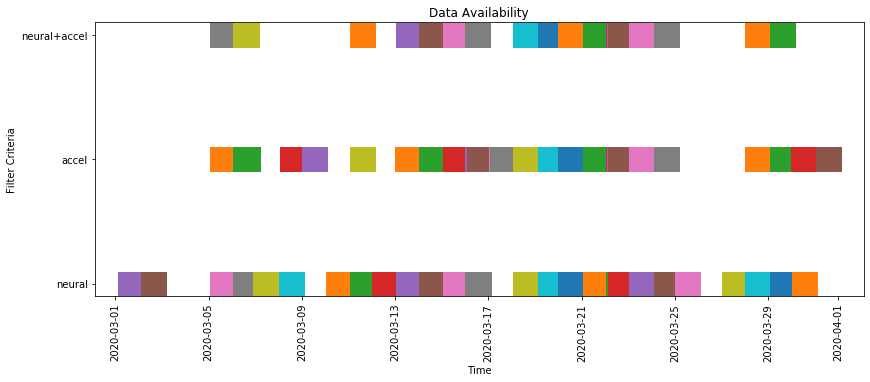

In [13]:
# plot data availability

plot_epochs(
    [
        'neural',
        'accel',
        'neural+accel'
    ], 
    epochs_neural, 
    epochs_accel, 
    epochs_neural_and_accel
)

To obtain the raw neural time series and accelerometry data, we can then loop through the `epochs` variable and use `get_neural_time_series` and `get_accel` from the previous notebooks `01_download_neural_data` and `02_download_watch_data`, respectively.

Other uses of the `availability` expression:
- Find bilateral data (run `check_neural_data_availability` for each hemisphere)
- After filtering for meta data and obtaining a list of epochs of neural data, loop through epochs and check accel availability 

## 2. Using the Graph API

The Graph API returns information about sessions, including start/end time of each session. We can obtain all session data within a certain time frame, and then cross check for overlap between neural and accel sessions. Note that the Graph API is more complicated to use and it is not supported by our Python package `runeq`.

We will use the same API credentials as before, but we will need to explicitly initialize them here. We do not need to specify device ID's, as the API will return sessions for all devices. `patient_id` can be found in the web app url's. The patient_id is what follows  `https://app.runelabs.io/patients/...` when you have selected that patient.

In [14]:
key_id = cfg.auth_headers['X-Rune-Client-Key-ID']
key_secret = cfg.auth_headers['X-Rune-Client-Access-Key']
patient_id = 'd629537621de441d8b713037bff1e8fd'
start_time = datetime.datetime(2020,3,1).timestamp()     
end_time = datetime.datetime(2020,4,1).timestamp()      

In [15]:
# Graph API request for sessions data within our time range

transport = RequestsHTTPTransport(
    url='https://graph.runelabs.io/graphql',
    use_json=True,
    headers={
        'Content-Type': "application/json",
        'X-Rune-Client-Key-Id': key_id,
        'X-Rune-Client-Access-Key': key_secret,
    }
)

gql_client = Client(
    retries=3,
    transport=transport,
    fetch_schema_from_transport=True,
)

resp = gql_client.execute(
    gql('''
        query ($patientId: ID!, $startTime: Float!, $endTime: Float!) {
            dataSessions(
                patientId: $patientId,
                startTime: $startTime,
                endTime: $endTime
            ) {
                id
                createdAt
                device {
                    id
                    alias
                    deviceType {
                        id
                    }
                }
                deviceSessionId
                endTime
                startTime
                streams {
                    streamName
                }
            }
        }
    '''),
    variable_values={
        "patientId": patient_id,
        "startTime": start_time,
        "endTime": end_time
    }
)

Next, we'll obtain a list of neural and accelerometry session start/end times.

In [16]:
# get session start/end times for watch and rcs

epochs_neural = []
epochs_accel = []

for session in resp['dataSessions']:
    if session['device']['deviceType']['id']=='RC+S':
        epochs_neural.append([session['startTime'], session['endTime']])
    elif session['device']['deviceType']['id']=='Apple Watch':
        epochs_accel.append([session['startTime'], session['endTime']])

In [17]:
# find overlap in epochs

epochs_neural_and_accel = find_overlapping_epochs(
    epochs_accel, 
    epochs_neural
)

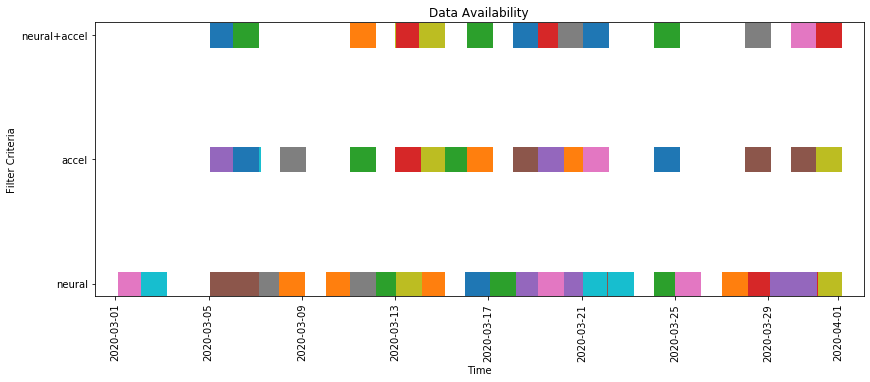

In [18]:
# plot epochs

plot_epochs(
    [
        'neural',
        'accel',
        'neural+accel'
    ], 
    epochs_neural, 
    epochs_accel, 
    epochs_neural_and_accel
)

In this plot, the data looks more sparse than it did in the previous plot using the `availability` expression. The `availability` expression returns a 1 for every time bin in which there is data found. Even if there is only 1 second of data, it will return a 1. Therefore, data can look more abundunt if you use a longer time resolution.

## Summary

Using two different methods, we checked for concurrent neural and watch data. Which method to use is dependent on the desired time resolution for data availability and post-processing workflows to define an epoch.